# Imbalanced Supervised Machine Learning
In this notebook, I have trained the following supervised ML models.

- Logistic Regression

- Support Vector Machine

- Random Forest

- XGBoost 

- Light GBM

- SMOTE with Random Forest

- Undersampling with Random Forest

The class distribution is 98 $\%$ majority class (non-fatal collisions) and 2 $\%$ minority class (fatal collisions). The optimizimation of the area under the receiver operating characteristic (AUROC) curve gives a slight improvement on the predictive power of the models.  SMOTE and Under Sampling techniques in combination with Random Forest classifier were applied on the training set, but they did not give any significant improvement on the imbalanced test set.

In [27]:
%matplotlib inline

# Ignore deprecated warning
import warnings
warnings.filterwarnings("ignore")

import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

plt.rcParams.update({'font.size': 15})

In [30]:
# Import custom classes
%run -i '../src/helper/01_transfxn.py'
%run -i '../src/helper/02_ml.py'

In [29]:
# Instantiate the classes
transfxn = TransformationPipeline()
model = SupervisedModels()

# Load data

In [4]:
df = pd.read_csv('../data/feat_engr_data.csv') # Load cleaned data
print('Data size',df.shape) # data size
df.head()

Data size (6771768, 42)


,c_year,c_mnth,c_wday,c_hour,class,c_vehs,c_conf,c_rcfg,c_wthr,c_rsur,...,c_rcfg_ct,hour_ct_per_day_ct,hour_ct_per_month_ct,pisev_ct_per_hour_ct,conf_ct_per_hour_ct,psafe_ct_per_hour_ct,wthr_ct_per_hour_ct,vtype_ct_per_hour_ct,rcfg_ct_per_hour_ct,c_conf_ind
0,1999,January,Monday,20.0,0,2.0,Right turn,NaN,Clear and sunny,Icy,...,NaN,0.278072,0.434034,10.981478,0.268553,NaN,18.938386,0.772580,NaN,N
1,1999,January,Monday,20.0,0,2.0,Right turn,NaN,Clear and sunny,Icy,...,NaN,0.278072,0.434034,10.981478,0.268553,NaN,18.938386,22.330975,NaN,N
2,1999,January,Monday,20.0,0,2.0,Right turn,NaN,Clear and sunny,Icy,...,NaN,0.278072,0.434034,14.194474,0.268553,19.230057,18.938386,22.330975,NaN,N
3,1999,January,Monday,8.0,0,1.0,Hit a moving object,NaN,"Freezing rain, sleet, hail",Snow,...,NaN,0.391691,0.611380,7.796031,0.286598,NaN,0.098990,15.853328,NaN,N
4,1999,January,Monday,8.0,0,1.0,Hit a moving object,NaN,"Freezing rain, sleet, hail",Snow,...,NaN,0.391691,0.611380,10.077019,0.286598,NaN,0.098990,NaN,NaN,N


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6771768 entries, 0 to 6771767
Data columns (total 42 columns):
 #   Column                Dtype  
---  ------                -----  
 0   c_year                int64  
 1   c_mnth                object 
 2   c_wday                object 
 3   c_hour                float64
 4   class                 int64  
 5   c_vehs                float64
 6   c_conf                object 
 7   c_rcfg                object 
 8   c_wthr                object 
 9   c_rsur                object 
 10  c_raln                object 
 11  c_traf                object 
 12  v_id                  float64
 13  v_type                object 
 14  v_year                float64
 15  p_id                  float64
 16  p_sex                 object 
 17  p_age                 float64
 18  p_psn                 object 
 19  p_isev                object 
 20  p_safe                object 
 21  p_user                object 
 22  c_case                int64  
 23  wday_ct

# Class distribution

In [6]:
label_pct = df['class'].value_counts(normalize = True)*100
label_ct =  df['class'].value_counts()
pd.DataFrame(
    {
        'labels': label_pct.index, 
        'count': label_ct.values, 
        'percentage': label_pct.values
    }
)

,labels,count,percentage
0,0,6659293,98.33906
1,1,112475,1.66094


# Descriptive statistics

In [7]:
df.drop(['class', 'p_id', 'v_id'], axis =1).describe()

,c_year,c_hour,c_vehs,v_year,p_age,c_case,wday_ct,mnth_ct,year_ct,hour_ct,...,v_type_ct,c_rcfg_ct,hour_ct_per_day_ct,hour_ct_per_month_ct,pisev_ct_per_hour_ct,conf_ct_per_hour_ct,psafe_ct_per_hour_ct,wthr_ct_per_hour_ct,vtype_ct_per_hour_ct,rcfg_ct_per_hour_ct
count,6.771768e+06,6.705458e+06,6.771201e+06,6.102074e+06,6.314556e+06,6.771768e+06,6.770404e+06,6.771343e+06,6.771768e+06,6.705458e+06,...,6.440489e+06,6.049634e+06,6.704640e+06,6.705314e+06,6.277187e+06,6.173829e+06,5.289712e+06,6.592229e+06,6.378820e+06,5.992100e+06
mean,2.007341e+03,1.370175e+01,2.047969e+00,1.999818e+03,3.673265e+01,1.273432e+06,9.770195e+05,5.698933e+05,3.618384e+05,3.848878e+05,...,4.852682e+06,2.665463e+06,3.975948e-01,6.819988e-01,1.141404e+01,3.281427e+00,1.518593e+01,1.237703e+01,1.740747e+01,9.500939e+00
std,5.453024e+00,5.166753e+00,1.244772e+00,7.690798e+00,1.850699e+01,7.423571e+05,9.878257e+04,5.374668e+04,4.404416e+04,1.566832e+05,...,1.856271e+06,7.545234e+05,1.673152e-01,2.877907e-01,1.052111e+01,3.790245e+00,1.459432e+01,1.381997e+01,1.771982e+01,8.795276e+00
min,1.999000e+03,0.000000e+00,1.000000e+00,1.901000e+03,1.000000e+00,1.000000e+00,8.113690e+05,4.526950e+05,2.898400e+05,4.484400e+04,...,9.490000e+02,6.340000e+02,3.888395e-02,7.117022e-02,7.629318e-02,2.307232e-02,2.321159e-05,2.952680e-02,1.573414e-03,1.051153e-03
25%,2.003000e+03,1.000000e+01,2.000000e+00,1.995000e+03,2.200000e+01,6.262348e+05,8.987790e+05,5.415500e+05,3.229840e+05,2.658360e+05,...,5.581069e+06,2.450279e+06,2.716118e-01,4.653258e-01,6.107406e+00,9.683758e-01,8.274048e+00,2.933946e+00,9.608269e+00,5.447381e+00
50%,2.007000e+03,1.400000e+01,2.000000e+00,2.000000e+03,3.500000e+01,1.271344e+06,9.571280e+05,5.932490e+05,3.685070e+05,4.257620e+05,...,5.581069e+06,3.164171e+06,3.991189e-01,7.092723e-01,8.145952e+00,2.283257e+00,1.126261e+01,1.028292e+01,1.307875e+01,7.265622e+00
75%,2.012000e+03,1.700000e+01,2.000000e+00,2.005000e+03,5.000000e+01,1.914787e+06,1.009002e+06,6.072220e+05,4.070360e+05,5.714810e+05,...,5.581069e+06,3.164171e+06,5.247452e-01,9.405052e-01,1.173846e+01,4.449727e+00,1.660501e+01,1.460244e+01,1.928263e+01,1.003723e+01
max,2.017000e+03,2.300000e+01,7.700000e+01,2.018000e+03,9.900000e+01,2.570235e+06,1.153278e+06,6.300950e+05,4.220750e+05,6.031470e+05,...,5.581069e+06,3.164171e+06,7.433695e-01,1.332347e+00,7.910878e+01,4.567360e+01,1.071731e+02,1.055476e+02,1.244552e+02,7.055952e+01


# Reduce dataset
The dataset is very large to fit into memory, so training models on the entire dataset will take days to run let alone tuning the hyperparameters by grid search.  Hence, we will first split the dataset into two subsets and train the model on the small subset

In [8]:
X1, X2, y1, y2 = train_test_split(df, df['class'], test_size=0.0015, 
                                  random_state=42, stratify=df['class']
                                 )

In [9]:
print(f'Large subset size: {X1.shape, y1.shape}')
print(f'Small subset size: { X2.shape, y2.shape}')

Large subset size: ((6761610, 42), (6761610,))
Small subset size: ((10158, 42), (10158,))


In [10]:
# Pickle the small subset
X2.to_pickle('../data/collision.pkl')

# Use reduced dataset for machine learning

In [4]:
# Reload the small subset
df_small = pd.read_pickle('../data/collision.pkl')

In [5]:
# Feature matrix and class label
cols_to_drop = ['c_case', 'p_id', 'v_id', 'class']
X, y = df_small.drop(cols_to_drop, axis = 1), df_small['class']

In [6]:
print('Data size:', X.shape, y.shape)

Data size: (10158, 38) (10158,)


# Create a test set
We now split the data set into $80\%$ training set and $20\%$ test set in a stratify fashion

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42, 
                                                    stratify=y
                                                   )

In [8]:
print(f'Training set size: {X_train.shape, y_train.shape}')
print(f'Test set size: {X_test.shape, y_test.shape}')

Training set size: ((8126, 38), (8126,))
Test set size: ((2032, 38), (2032,))


In [9]:
print(f'Training set class distribution:\n {(y_train.value_counts()/X_train.shape[0])*100}')
print('--' * 15)
print(f'Test set class distribution:\n {(y_test.value_counts()/X_test.shape[0])*100}')

Training set class distribution:
 0    98.338666
1     1.661334
Name: class, dtype: float64
------------------------------
Test set class distribution:
 0    98.326772
1     1.673228
Name: class, dtype: float64


# Data preprocessing

In [10]:
# Transform and scale data
X_train_scaled, X_test_scaled, feat_names = transfxn.preprocessing(X_train, X_test)

In [11]:
# Size of the data after pre-processing
print(f'Training set size after pre-processing: {X_train_scaled.shape}')
print(f'Test set size after pre-processing: {X_test_scaled.shape}')

Training set size after pre-processing: (8126, 153)
Test set size after pre-processing: (2032, 153)


In [12]:
# Convert the class labels to arrays
y_train, y_test = y_train.values,  y_test.values

# Model Training

## Section A-1. Logistic Regression

In [20]:
log_clf = LogisticRegression(random_state=42)  
log_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(log_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='Logistic Regression',
                )

Predictions on the training set for Logistic Regression
------------------------------------------------------------
Accuracy:  0.990524
AUROC: 0.924253
AUPRC: 0.615404
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section A-2. Cross-validation for Logistic Regression

In [21]:
model.prediction_cv(log_clf, X_train_scaled, y_train, cv_fold=10, 
                      scoring='accuracy',
                      model_nm="Logistic Regression",
                     )

10-fold cross-validation for Logistic Regression
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001354)
AUROC: 0.833831
AUPRC: 0.531305
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section A-3.  Hyperparameter tuning - Logistic Regression
 In this section, we shall optimize the **AUC** of the classifiers using grid/randomized search, cross-validation, and cost sensitive method

In [22]:
# Class ratio of the 
# negative class to the positive class
neg = y_train == 0
pos = y_train == 1
class_ratio = np.sum(neg)/np.sum(pos)
class_ratio

59.19259259259259

In [23]:
# Range of hyperparameters
params = {
    'C': [2**x for x in range(-2,5,2)],
    'class_weight': ['balanced', None, {0:1, 1:class_ratio}],
}
                             
# Grid search
log_clf = LogisticRegression()   
gsearch_log = RandomizedSearchCV(estimator=log_clf, param_distributions=params, 
                                scoring='roc_auc', cv=10, n_jobs=-1, 
                                n_iter=200, random_state=42, verbose=1
                                )

# Fit the training set
gsearch_log.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(gsearch_log.best_estimator_, '../src/model/log_clf.pkl')

# Print results
print('Best AUC score:', gsearch_log.best_score_)
print('Best parameters:', gsearch_log.best_params_)    

Fitting 10 folds for each of 12 candidates, totalling 120 fits
Best AUC score: 0.848512321376996
Best parameters: {'class_weight': None, 'C': 16}


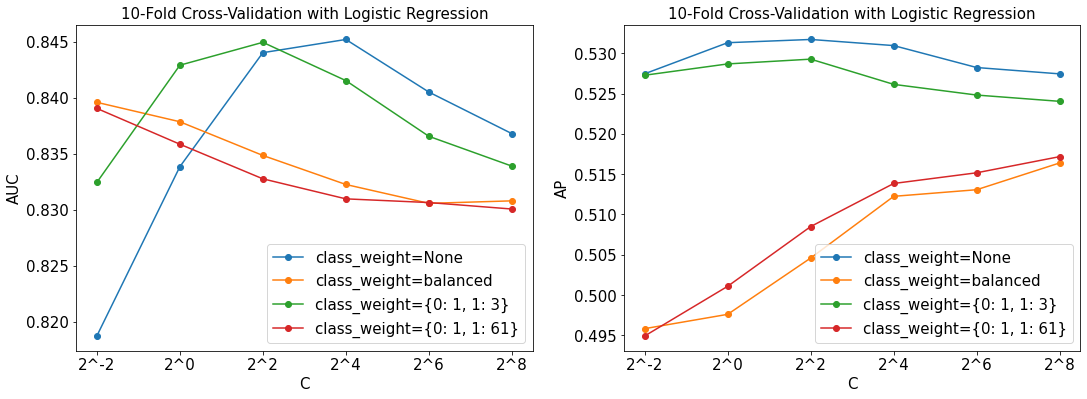

In [24]:
model.plot_auc_ap_lr(X_train_scaled, y_train, cv_fold=10)

## Section B-1. Support Vector Machine

In [25]:
svm_clf = SVC(probability=True, kernel='rbf', random_state=42)  
svm_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(svm_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='SVM Classifier',
                )

Predictions on the training set for SVM Classifier
------------------------------------------------------------
Accuracy:  0.990524
AUROC: 1.000000
AUPRC: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section B-2. Cross-validation for SVM

In [26]:
model.prediction_cv(svm_clf, X_train_scaled, y_train, cv_fold=10, 
                    scoring='accuracy', 
                    model_nm="SVM Classifier",
                   )

10-fold cross-validation for SVM Classifier
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001354)
AUROC: 0.807061
AUPRC: 0.494470
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section B-3. Hyperparameter tuning- SVM

In [27]:
# Range of hyperparameters
params = {
    'C': [2**x for x in range(-2,8,2)], 
    'gamma': [2**x for x in range(-11,1,2)],
    'class_weight': ['balanced', None, {0:1, 1:class_ratio}],
         } 
                                                              
# Randomized search for SVM
svm_clf = SVC(probability=True, kernel='rbf')
rsearch_svm = RandomizedSearchCV(svm_clf, param_distributions=params, cv=10,
                                 scoring='roc_auc', n_iter=200,
                                 n_jobs=-1, random_state=42, verbose=1
                                ) 
# Fit the training set
rsearch_svm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_svm.best_estimator_, '../src/model/svm_clf.pkl')

print('Best AUC score: ', rsearch_svm.best_score_)
print('Best parameters: ', rsearch_svm.best_params_)  

Fitting 10 folds for each of 90 candidates, totalling 900 fits
Best AUC score:  0.8519805457371165
Best parameters:  {'gamma': 0.001953125, 'class_weight': {0: 1, 1: 59.19259259259259}, 'C': 4}


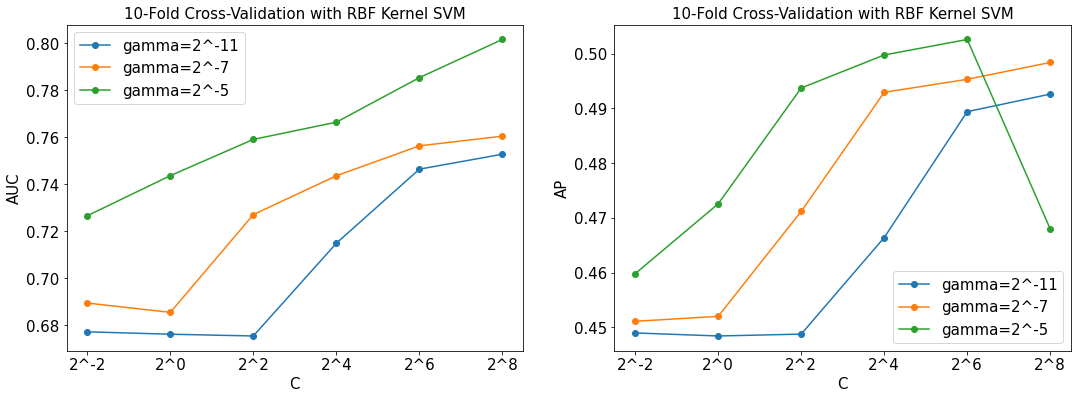

In [28]:
model.plot_auc_ap_svm(X_train_scaled, y_train, cv_fold=10, class_weight=None)

## Section C-1. Random Forest

In [29]:
rf_clf = RandomForestClassifier(random_state=42)   
rf_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(rf_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='Random Forest Classifier',
                )

Predictions on the training set for Random Forest Classifier
------------------------------------------------------------
Accuracy:  1.000000
AUROC: 1.000000
AUPRC: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [   0  135]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7991
           1       1.00      1.00      1.00       135

    accuracy                           1.00      8126
   macro avg       1.00      1.00      1.00      8126
weighted avg       1.00      1.00      1.00      8126

------------------------------------------------------------


## Section C-2. Cross-validation for Random Forest

In [30]:
rf_clf = RandomForestClassifier(random_state = 42)                         
model.prediction_cv(rf_clf, X_train_scaled, y_train, cv_fold=10, 
                    scoring='accuracy', 
                    model_nm="Random Forest Classifier",
                   )

10-fold cross-validation for Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001354)
AUROC: 0.818323
AUPRC: 0.528765
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.43      0.60       135

    accuracy                           0.99      8126
   macro avg       1.00      0.71      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


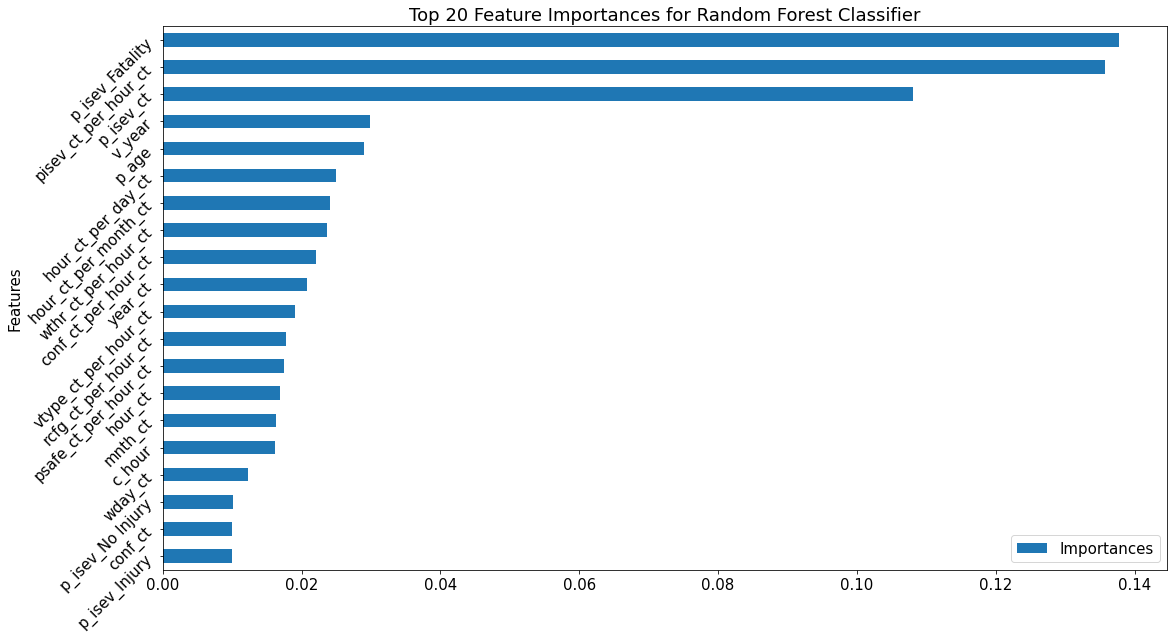

In [31]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
        'Features': feat_names, 
        'Importances': rf_clf.feature_importances_,
    }
)
# Bar plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 20 Feature Importances for Random Forest Classifier')
plt.show()

## Section C-3.  Hyperparameter tuning - Random Forest

In [32]:
# Range of hyperparameters
params = {
    'max_features': [0.5, 1, 'sqrt', 'log2', None],
    'max_depth': range(2,8,1),
    'min_samples_split': range(2,10,1),
    'class_weight': ['balanced', None, {0: 1, 1: class_ratio}],
}

# Randomized search
rf_clf = RandomForestClassifier(n_estimators=1000, random_state=42)           
rsearch_rf = RandomizedSearchCV(estimator=rf_clf, param_distributions=params, 
                                scoring='roc_auc', cv=10, n_jobs=-1, n_iter=200, 
                                random_state=42, verbose=1
                               )  
# Fit the  training set                                                    
rsearch_rf.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_rf.best_estimator_, '../src/model/rf_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_rf.best_score_) 
print('Randomized search best hyperparameters:', rsearch_rf.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.8818015849138348
Randomized search best hyperparameters: {'min_samples_split': 8, 'max_features': None, 'max_depth': 3, 'class_weight': None}


## Section D-1. XGBoost

In [33]:
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'learning_rate':0.05, 
    'random_state':42,
    'n_jobs':-1,
    'n_estimators':100,
}
              
xgb_clf = xgb.XGBClassifier(**param_dist)
xgb_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(xgb_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='XGBoost Classifier',
                )

Predictions on the training set for XGBoost Classifier
------------------------------------------------------------
Accuracy:  0.991878
AUROC: 0.981212
AUPRC: 0.825297
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [  66   69]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.51      0.68       135

    accuracy                           0.99      8126
   macro avg       1.00      0.76      0.84      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


## Section D-2: Cross-validation for XGBoost

In [34]:
model.prediction_cv(xgb_clf, X_train_scaled, y_train, 
                    cv_fold=10, scoring='accuracy',
                    model_nm="XGBoost Classifier",
                   )

10-fold cross-validation for XGBoost Classifier
------------------------------------------------------------
Accuracy (std): 0.990278 (0.001398)
AUROC: 0.853077
AUPRC: 0.537025
Predicted classes: [0 1]
Confusion matrix:
 [[7989    2]
 [  77   58]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.97      0.43      0.59       135

    accuracy                           0.99      8126
   macro avg       0.98      0.71      0.79      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


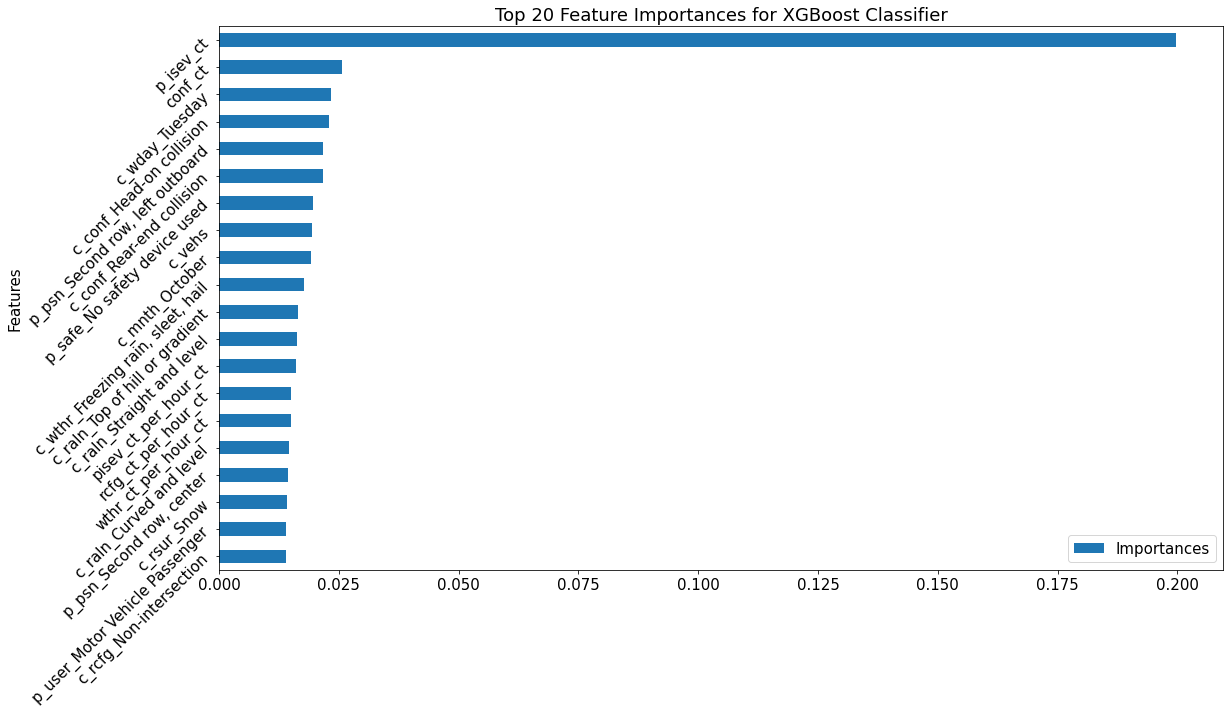

In [35]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
    'Features': feat_names,
    'Importances': xgb_clf.feature_importances_,
    }
)
# Bar plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace=True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 20 Feature Importances for XGBoost Classifier')
plt.show()

## Section D-3. Hyperparameter tuning  - XGBoost

In [36]:
# Range of hyperparameters
params = {'max_depth': range(1,10,2), 
          'min_child_weight': range(1,6,2),
          'gamma':[i/100 for i in range(0,6)],
          'subsample':[i/10 for i in range(5,9)],
          'colsample_bytree': [i/10 for i in range(5,9)],
          'learning_rate': [0.01, 0.02, 0.05, 0.1],
          }

# Randomized search
param_dist = {
    'objective':'binary:logistic', 
    'eval_metric':'logloss', 
    'n_estimators':100,
    'scale_pos_weight':class_ratio, 
    'random_state':42,
            }     
xgb_clf = xgb.XGBClassifier(**param_dist)
rsearch_xgb = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, 
                                  scoring='roc_auc', cv=10, n_jobs=-1, n_iter=200, 
                                  random_state=42, verbose=1
                                )   
# Fit the  training set                                                            
rsearch_xgb.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_xgb.best_estimator_, '../src/model/xgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_xgb.best_score_) 
print('Randomized search best hyperparameters:', rsearch_xgb.best_params_) 

Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Randomized search best AUC score: 0.8671791860361167
Randomized search best hyperparameters: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 0.04, 'colsample_bytree': 0.8}


## Section E-1. LGBM

In [37]:
param_dict = {
    'boosting_type':'gbdt', 
    'num_leaves':31, 
    'max_depth':- 1, 
    'learning_rate':0.05, 
    'n_estimators':100, 
    'random_state':42,
}
lgb_clf = lgb.LGBMClassifier(**param_dict)
lgb_clf.fit(X_train_scaled, y_train)

# Prediction on the training set
model.prediction(lgb_clf, X_train_scaled, y_train, 
                 subset='training set',
                 model_nm='LGBM Classifier',
                )

Predictions on the training set for LGBM Classifier
------------------------------------------------------------
Accuracy:  0.999754
AUROC: 1.000000
AUPRC: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [   2  133]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7991
           1       1.00      0.99      0.99       135

    accuracy                           1.00      8126
   macro avg       1.00      0.99      1.00      8126
weighted avg       1.00      1.00      1.00      8126

------------------------------------------------------------


## Section E-2. Cross-validation for LGBM

In [38]:
model.prediction_cv(lgb_clf, X_train_scaled, y_train, 
                    cv_fold=10, model_nm='LGBM Classifier'
                   )

10-fold cross-validation for LGBM Classifier
------------------------------------------------------------
Accuracy (std): 0.990524 (0.001462)
AUROC: 0.853481
AUPRC: 0.517834
Predicted classes: [0 1]
Confusion matrix:
 [[7990    1]
 [  76   59]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       0.98      0.44      0.61       135

    accuracy                           0.99      8126
   macro avg       0.99      0.72      0.80      8126
weighted avg       0.99      0.99      0.99      8126

------------------------------------------------------------


Text(0.5, 1.0, 'Top 10 Feature Importances for LGBM Classifier')

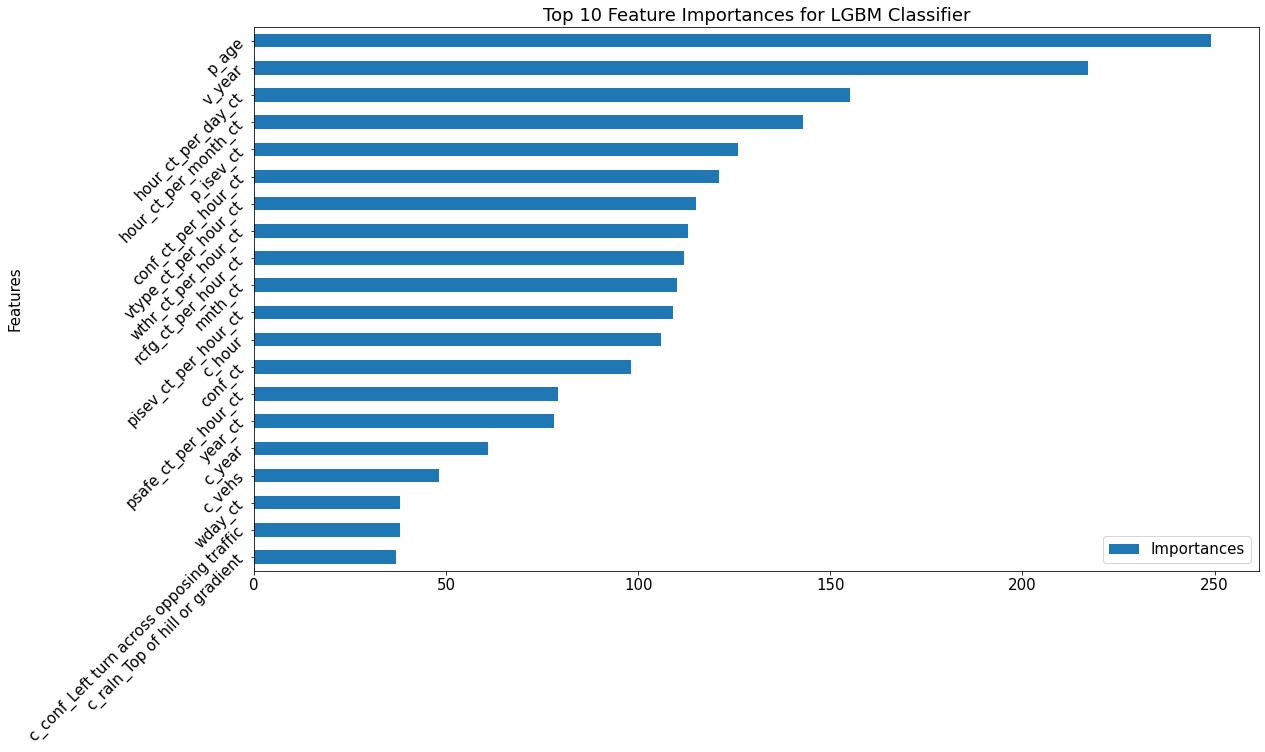

In [39]:
# Compute feature importances
importances_df = pd.DataFrame(
    {
        'Features': feat_names, 
        'Importances': lgb_clf.feature_importances_,
    }
)
# Plot
importances_df.sort_values('Importances', ascending=True, inplace=True)
importances_df.set_index('Features', inplace = True)
importances_df.tail(20).plot(kind='barh', figsize=(18,10))
plt.yticks(rotation=45)
plt.title('Top 10 Feature Importances for LGBM Classifier')
# plt.savefig('../image/lgbm.png')

## Section E-3. Hyperparameter tuning  - LGBM

In [40]:
# Hyperparameter range
params = {'max_depth': [-1,30,40],
          'num_leaves': range(80,120,10),
          'min_child_samples': range(20,50,10),
          'learning_rate': [0.01, 0.02, 0.05, 0.1],
          }

# Randomized search
param_dict = {'boosting_type':'gbdt', 
              'n_estimators':100, 
              'random_state':42,
              'scale_pos_weight':class_ratio,
             }
             
lgb_clf =  lgb.LGBMClassifier(**param_dict)                       
rsearch_lgbm = RandomizedSearchCV(estimator=lgb_clf, param_distributions=params, 
                                n_iter=200, scoring='roc_auc', cv=10, 
                                n_jobs=-1, random_state=42, verbose=1
                                 )  
# Fit model
rsearch_lgbm.fit(X_train_scaled, y_train)

# Pickle trained model
joblib.dump(rsearch_lgbm.best_estimator_, '../src/model/lgb_clf.pkl')

# Print results
print('Randomized search best AUC score:', rsearch_lgbm.best_score_) 
print('Best hyperparameters:', rsearch_lgbm.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Randomized search best AUC score: 0.8395908587657648
Best hyperparameters: {'num_leaves': 110, 'min_child_samples': 30, 'max_depth': -1, 'learning_rate': 0.02}


In [21]:
# Load trained model
log_clf = joblib.load('../src/model/log_clf.pkl')
svm_clf = joblib.load('../src/model/svm_clf.pkl')
rf_clf = joblib.load('../src/model/rf_clf.pkl')
xgb_clf = joblib.load('../src/model/xgb_clf.pkl')
lgb_clf = joblib.load('../src/model/lgb_clf.pkl')

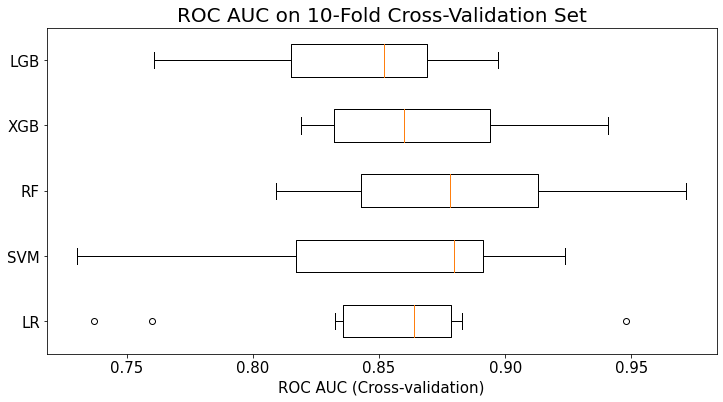

In [42]:
model_dict = {
    'LR': log_clf, 
    'SVM': svm_clf, 
    'RF': rf_clf, 
    'XGB': xgb_clf, 
    'LGB': lgb_clf,
}

roc_scores = []
for i, (name, model) in enumerate(model_dict.items()):
    score = cross_val_score(model, X_train_scaled, y_train, cv=10, scoring='roc_auc')
    roc_scores.append(score)

plt.figure(figsize=(12,6))
plt.boxplot(roc_scores, vert=False)
plt.yticks(np.arange(len(model_dict))+1, list(model_dict.keys()))
plt.title('ROC AUC on 10-Fold Cross-Validation Set', fontsize=20)
plt.xlabel('ROC AUC (Cross-validation)')
plt.savefig('../image/cv_metric.png')
plt.show()

# Section F. Resampling Methods
In this section, we will employ two resampling techniques on the training set to balance the classes. However, the final prediction will be made on the imbalanced test set. The idea of resampling is to trick the classifier using a balanced dataset.  

## Section F-1. Under Sampling  combined with Random Forest Classifier
In undersampling, we reduce the majority class such that it matches the minority class

In [13]:
# Under sample the majority class
und = RandomUnderSampler(random_state=42)
X_train_scaled_und, y_train_und = und.fit_resample(X_train_scaled, y_train)

In [14]:
print('Undersampled training data size:', X_train_scaled_und.shape, y_train_und.shape)

Undersampled training data size: (270, 153) (270,)


In [15]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('Undersampled training set class distribution:', np.bincount(y_train_und))

Imbalanced training set class distribution: [7991  135]
Undersampled training set class distribution: [135 135]


In [33]:
param_dist = {
    'n_estimators':100, 
    'random_state':42,
    'n_jobs':-1,
}   
rf_und = RandomForestClassifier(**param_dist)
rf_und.fit(X_train_scaled_und, y_train_und)

# Prediction on the training set
model.prediction(rf_und, X_train_scaled_und, y_train_und, 
                 subset='training set',
                 model_nm='Undersampling with Random Forest Classifier',
                )

Predictions on the training set for Undersampling with Random Forest Classifier
------------------------------------------------------------
Accuracy:  1.000000
AUROC: 1.000000
AUPRC: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[135   0]
 [  0 135]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       135
           1       1.00      1.00      1.00       135

    accuracy                           1.00       270
   macro avg       1.00      1.00      1.00       270
weighted avg       1.00      1.00      1.00       270

------------------------------------------------------------


In [16]:
# Random Forest cross-validation on the undersampled dataset
model.prediction_cv(rf_und, X_train_scaled_und, y_train_und, 
                    cv_fold=10, scoring='accuracy', 
                    model_nm="Undersampling with Random Forest Classifier",
                   )

10-fold cross-validation for Undersampling with Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.792593 (0.037771)
AUROC: 0.858436
AUPRC: 0.887455
Predicted classes: [0 1]
Confusion matrix:
 [[115  20]
 [ 36  99]]
Classification report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       135
           1       0.83      0.73      0.78       135

    accuracy                           0.79       270
   macro avg       0.80      0.79      0.79       270
weighted avg       0.80      0.79      0.79       270

------------------------------------------------------------


## Section F-2. SMOTE  combined with Random Forest Classifier
In Synthetic Minority Over Sampling Technique (SMOTE), we generate synthetic oberservations to match the minority clas.
SMOTE oversampled the minority class in the training set, so we now have equal class distribution. 

In [17]:
# Over sample the minority class
sm = SMOTE(random_state = 42)
X_train_scaled_ovsm, y_train_ovsm = sm.fit_resample(X_train_scaled, y_train)

In [18]:
print('SMOTE training data size:', X_train_scaled_ovsm.shape, y_train_ovsm.shape)

SMOTE training data size: (15982, 153) (15982,)


In [19]:
print('Imbalanced training set class distribution:', np.bincount(y_train))
print('SMOTE resampled training set class distribution:', np.bincount(y_train_ovsm))

Imbalanced training set class distribution: [7991  135]
SMOTE resampled training set class distribution: [7991 7991]


In [34]:
param_dist = {
    'n_estimators':100, 
    'random_state':42,
    'n_jobs':-1,
}   
rf_ovsm = RandomForestClassifier(**param_dist)
rf_ovsm.fit(X_train_scaled_ovsm, y_train_ovsm)

# Prediction on the training set
model.prediction(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, 
                 subset='training set',
                 model_nm='SMOTE with Random Forest Classifier',
                )

Predictions on the training set for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy:  1.000000
AUROC: 1.000000
AUPRC: 1.000000
Predicted classes: [0 1]
Confusion matrix:
 [[7991    0]
 [   0 7991]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7991
           1       1.00      1.00      1.00      7991

    accuracy                           1.00     15982
   macro avg       1.00      1.00      1.00     15982
weighted avg       1.00      1.00      1.00     15982

------------------------------------------------------------


In [20]:
# Random Forest cross-validation on the SMOTE dataset
model.prediction_cv(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, 
                    cv_fold=10, scoring='accuracy', 
                    model_nm="SMOTE with Random Forest Classifier",
                   )

10-fold cross-validation for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy (std): 0.995622 (0.011690)
AUROC: 0.999920
AUPRC: 0.999917
Predicted classes: [0 1]
Confusion matrix:
 [[7984    7]
 [  63 7928]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      7991
           1       1.00      0.99      1.00      7991

    accuracy                           1.00     15982
   macro avg       1.00      1.00      1.00     15982
weighted avg       1.00      1.00      1.00     15982

------------------------------------------------------------


# Section G. Prediction on the Imbalanced Test Set 
In this section, we make our final prediction on the imbalanced dataset after training the model using the resampling techniques.

## Section G-1. Normal imbalanced model

In [22]:
model.prediction(rf_clf, X_test_scaled, y_test,
                 subset='test set',
                 model_nm="Random Forest Classifier",
                )

Predictions on the test set for Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.990650
AUROC: 0.856136
AUPRC: 0.548553
Predicted classes: [0 1]
Confusion matrix:
 [[1998    0]
 [  19   15]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1998
           1       1.00      0.44      0.61        34

    accuracy                           0.99      2032
   macro avg       1.00      0.72      0.80      2032
weighted avg       0.99      0.99      0.99      2032

------------------------------------------------------------


## Section G-2. Undersampled model

In [23]:
model.prediction(rf_und, X_test_scaled, y_test,
                subset='test set',
                model_nm="UnderSampling with Random Forest Classifier",
               )

Predictions on the test set for UnderSampling with Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.832677
AUROC: 0.889875
AUPRC: 0.434811
Predicted classes: [0 1]
Confusion matrix:
 [[1664  334]
 [   6   28]]
Classification report:
               precision    recall  f1-score   support

           0       1.00      0.83      0.91      1998
           1       0.08      0.82      0.14        34

    accuracy                           0.83      2032
   macro avg       0.54      0.83      0.52      2032
weighted avg       0.98      0.83      0.89      2032

------------------------------------------------------------


## Section G-3. SMOTE model

In [24]:
model.prediction(rf_ovsm, X_test_scaled, y_test,
                subset='test set',
                model_nm="SMOTE with Random Forest Classifier",
               )

Predictions on the test set for SMOTE with Random Forest Classifier
------------------------------------------------------------
Accuracy:  0.990157
AUROC: 0.865895
AUPRC: 0.544427
Predicted classes: [0 1]
Confusion matrix:
 [[1997    1]
 [  19   15]]
Classification report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1998
           1       0.94      0.44      0.60        34

    accuracy                           0.99      2032
   macro avg       0.96      0.72      0.80      2032
weighted avg       0.99      0.99      0.99      2032

------------------------------------------------------------


# Section H.  ROC and PR Curves

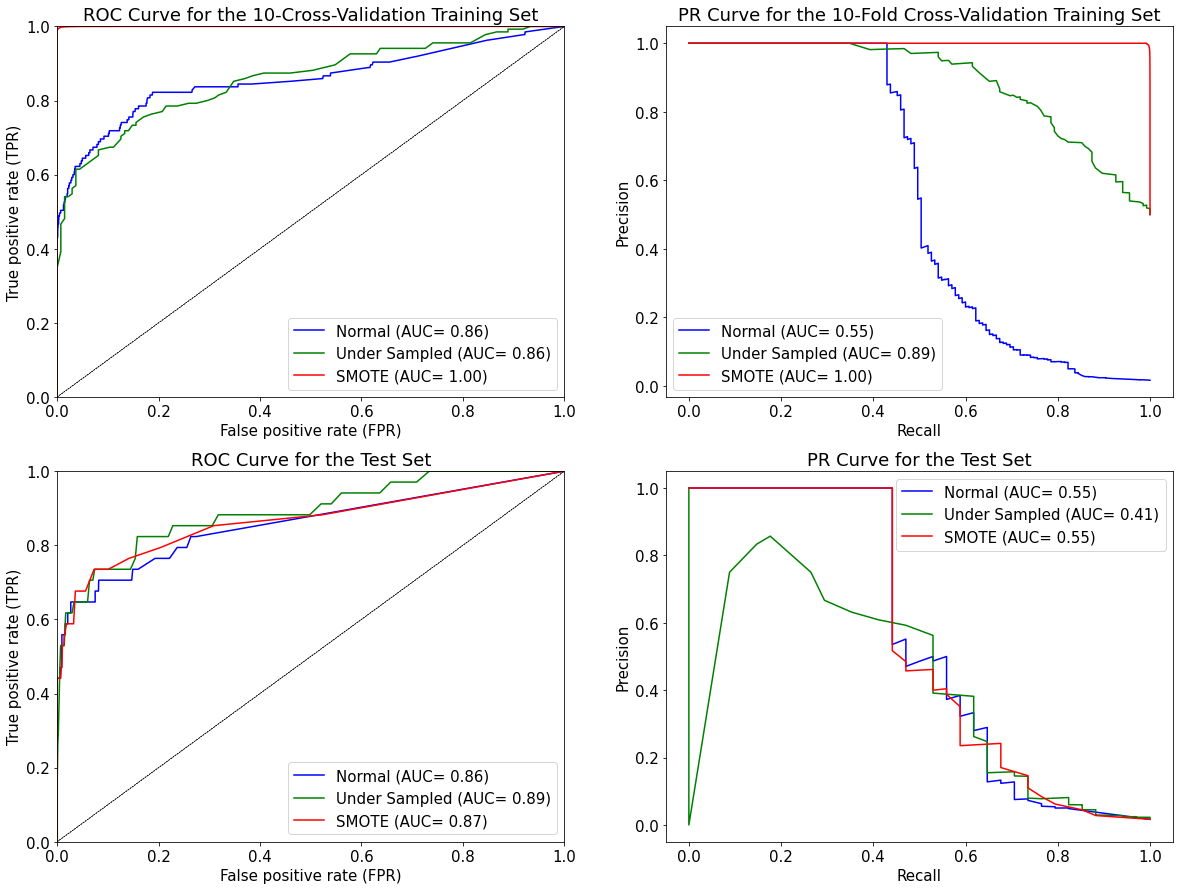

In [31]:
plt.figure(figsize=(20,15))

# Normal imbalanced distribution
model.plot_roc_pr_curves(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                         cv_fold=10, color='b', label='Normal (AUC= %0.2f)',
                        )

# Under Sampled distribution
model.plot_roc_pr_curves(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, 
                         cv_fold=10, color='g', label='Under Sampled (AUC= %0.2f)',
                        )
                     
# SMOTE distribution
model.plot_roc_pr_curves(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test, 
                         cv_fold=10, color='r', label='SMOTE (AUC= %0.2f)',
                        ) 

# Section I. AUC-ROC & AUC-PR for Cross-Validation & Test Sets

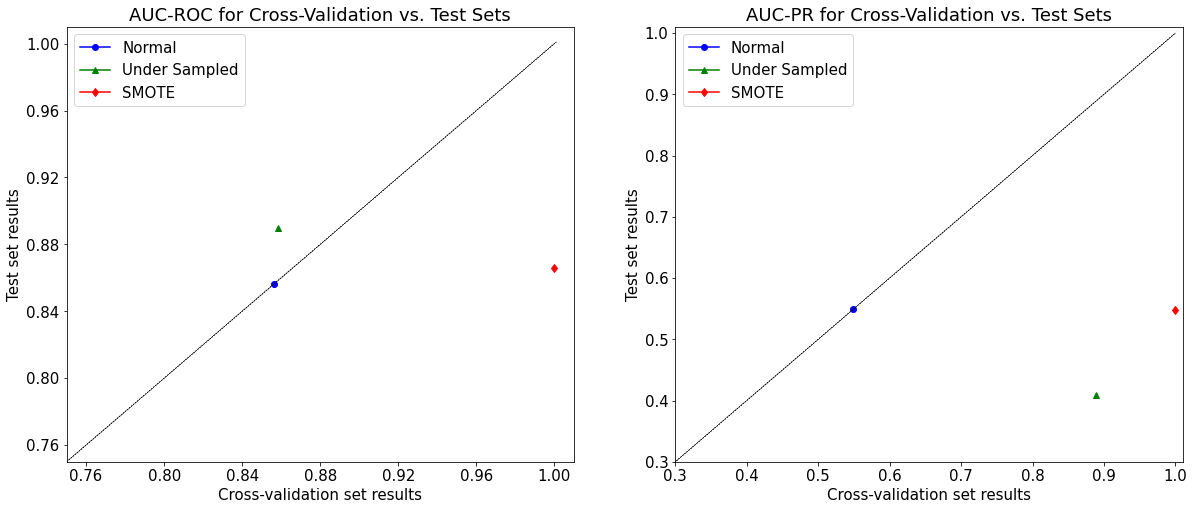

In [32]:
plt.figure(figsize=(20,8))

# Normal imbalanced distribution
model.plot_aucroc_aucpr(rf_clf, X_train_scaled, y_train, X_test_scaled, y_test, 
                        cv_fold=10, marker='o', color='b', label='Normal',
                       )

# Under Sampled distribution
model.plot_aucroc_aucpr(rf_und, X_train_scaled_und, y_train_und, X_test_scaled, y_test, 
                        cv_fold=10, marker='^', color='g', label='Under Sampled',
                       )
                     
# SMOTE distribution
model.plot_aucroc_aucpr(rf_ovsm, X_train_scaled_ovsm, y_train_ovsm, X_test_scaled, y_test,
                        cv_fold=10, marker='d', color='r', label='SMOTE',
                       ) 